In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import MinMaxScaler

In [2]:
file_energy = Path("Energy00_22.csv")
file_cpi = Path("CPI_Average.csv")

In [3]:
energy_file = pd.read_csv(file_energy)
CPI_file = pd.read_csv(file_cpi)

In [4]:
df_energy = pd.DataFrame(energy_file)
df_energy.set_index(pd.to_datetime(df_energy['Year'], infer_datetime_format=True), inplace=True)
df_energy = df_energy.drop(columns=['Year'], axis=1)
df_energy = df_energy.pct_change()


df_cpi = pd.DataFrame(CPI_file)
df_cpi.set_index(pd.to_datetime(df_cpi['Year'], infer_datetime_format=True), inplace=True) 
df_cpi = df_cpi.drop(columns=['Year'], axis=1)
df_cpi  = df_cpi.pct_change()

In [5]:
df_inflation = pd.concat([df_energy,df_cpi], axis="columns", join = "inner")

In [6]:
df_inflation.head()

,Energy,CPI
Year,,
2000-01-01,NaN,0.002971
2000-02-01,0.034930,0.005924
2000-03-01,0.050145,0.008245
2000-04-01,-0.010101,0.000584
2000-05-01,0.001855,0.001168


In [7]:
def fill_missing(values):
    one_month = 30
    for row in range(df_inflation.shape[0]):
        for col in range(df_inflation.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_month,col]
df_inflation = df_inflation.astype('float32')
fill_missing(df_inflation.values)
df_inflation.isnull().sum()

Energy    0
CPI       0
dtype: int64

In [8]:
def window_data(df_inflation, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df_inflation) - window):
        features = df_inflation.iloc[i : (i + window), feature_col_number]
        target = df_inflation.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
 # Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_inflation, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:10]} \n")
print (f"y sample values:\n{y[:10]}")


X sample values:
[[ 0.00297089  0.00592417  0.00824499  0.00058411  0.00116754  0.00524781
   0.00232019  0.          0.00520833  0.00172712  0.00057471 -0.00057438
   0.00632184  0.00399772  0.00227531  0.00397276  0.00452233  0.00168824
  -0.00280899  0.          0.00450704 -0.00336512 -0.00168824 -0.00394589
   0.00226372  0.00395257  0.0056243   0.00559284  0.          0.00055617]
 [ 0.00592417  0.00824499  0.00058411  0.00116754  0.00524781  0.00232019
   0.          0.00520833  0.00172712  0.00057471 -0.00057438  0.00632184
   0.00399772  0.00227531  0.00397276  0.00452233  0.00168824 -0.00280899
   0.          0.00450704 -0.00336512 -0.00168824 -0.00394589  0.00226372
   0.00395257  0.0056243   0.00559284  0.          0.00055617  0.00111173]
 [ 0.00824499  0.00058411  0.00116754  0.00524781  0.00232019  0.
   0.00520833  0.00172712  0.00057471 -0.00057438  0.00632184  0.00399772
   0.00227531  0.00397276  0.00452233  0.00168824 -0.00280899  0.
   0.00450704 -0.00336512 -0.001688

In [10]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.70518863]
  [0.7993237 ]
  [0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777]
  [0.6104926 ]
  [0.7765066 ]
  [0.66554385]
  [0.62881136]
  [0.5921843 ]
  [0.81199926]
  [0.73791856]
  [0.6830175 ]
  [0.737123  ]
  [0.75464046]
  [0.6643047 ]
  [0.52095693]
  [0.6104926 ]
  [0.7541532 ]
  [0.5032306 ]
  [0.5566805 ]
  [0.4847187 ]
  [0.68264806]
  [0.7364795 ]
  [0.7897653 ]
  [0.7887627 ]
  [0.6104926 ]
  [0.62822044]]

 [[0.7993237 ]
  [0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777]
  [0.6104926 ]
  [0.7765066 ]
  [0.66554385]
  [0.62881136]
  [0.5921843 ]
  [0.81199926]
  [0.73791856]
  [0.6830175 ]
  [0.737123  ]
  [0.75464046]
  [0.6643047 ]
  [0.52095693]
  [0.6104926 ]
  [0.7541532 ]
  [0.5032306 ]
  [0.5566805 ]
  [0.4847187 ]
  [0.68264806]
  [0.7364795 ]
  [0.7897653 ]
  [0.7887627 ]
  [0.6104926 ]
  [0.62822044]
  [0.6459286 ]]

 [[0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777

In [13]:
model = Sequential()

# Initial model setup
number_units = 400
#hidden_units = 17 
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))


# Output layer
model.add(Dense(1))

In [14]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 400)           643200    
_________________________________________________________________
dropout (Dropout)            (None, 30, 400)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1

In [16]:
model.fit(X_train, y_train, epochs=500, shuffle=False, batch_size=100, verbose=1)

Epoch 1/500
2/2 [==============================] - 10s 2s/step - loss: 0.3184
Epoch 2/500
2/2 [==============================] - 4s 2s/step - loss: 5.5107
Epoch 3/500
2/2 [==============================] - 4s 2s/step - loss: 0.3477
Epoch 4/500
2/2 [==============================] - 4s 2s/step - loss: 0.4021
Epoch 5/500
2/2 [==============================] - 4s 2s/step - loss: 0.3605
Epoch 6/500
2/2 [==============================] - 4s 2s/step - loss: 0.2866
Epoch 7/500
2/2 [==============================] - 4s 2s/step - loss: 0.1453
Epoch 8/500
2/2 [==============================] - 4s 2s/step - loss: 0.0672
Epoch 9/500
2/2 [==============================] - 4s 2s/step - loss: 0.0719
Epoch 10/500
2/2 [==============================] - 4s 2s/step - loss: 0.0329
Epoch 11/500
2/2 [==============================] - 4s 2s/step - loss: 0.0680
Epoch 12/500
2/2 [==============================] - 4s 2s/step - loss: 0.0614
Epoch 13/500
2/2 [==============================] - 4s 2s/step - loss: 0

In [17]:
model.evaluate(X_test, y_test, verbose=0)

0.01477038860321045

In [18]:
predicted = model.predict(X_test)

In [19]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Create a DataFrame of Real and Predicted values
CPI = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_inflation.index[-len(real_prices): ]) 

# Show the DataFrame's head
CPI.tail()

,Actual,Predicted
Year,,
2022-01-01,0.008415,0.000467
2022-02-01,0.009134,0.001266
2022-03-01,0.013351,0.001899
2022-04-01,0.005583,0.002323
2022-05-01,0.011024,0.002442


<AxesSubplot:title={'center':'Actual Vs. Predicted'}, xlabel='Year'>

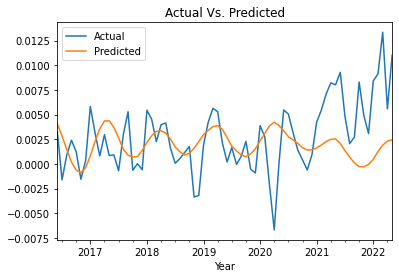

In [21]:
CPI.plot(title="Actual Vs. Predicted")

In [22]:
# Print the Classification Report
from sklearn.metrics import classification_report
print(classification_report(results.Actual, results.Predicted))

NameError: name 'results' is not defined